[Source](https://https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os

In [ ]:
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
# Mount google drive to have access to images
from google.colab import drive
drive.mount('/content/gdrive')



# **Deep Learning Machine Learning**



In [ ]:
img_height = 224
img_width = 224
train_dir = '/content/gdrive/MyDrive/xray/chest_xray/train'
test_dir = '/content/gdrive/MyDrive/xray/chest_xray/test'

In [ ]:
# Read IMAGES
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.1,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=128)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.1,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=128)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=128)

Found 5232 files belonging to 2 classes.
Using 4709 files for training.
Found 5232 files belonging to 2 classes.
Using 523 files for validation.
Found 624 files belonging to 2 classes.


In [ ]:
# Prepare test dataset
test_image, test_labels = test_ds.as_numpy_iterator().next()

In [ ]:
# Configure the dataset for performance when loading data 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Standardise data
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, img_width,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1)
    # tf.keras.layers.experimental.preprocessing.RandomZoom(0.05),
  ]
)

## Simple CNN ##

Epoch 1/80
37/37 [==============================] - 23s 596ms/step - loss: 4.9294 - binary_accuracy: 0.6740 - val_loss: 3.7030 - val_binary_accuracy: 0.7572
Epoch 2/80
37/37 [==============================] - 22s 590ms/step - loss: 5.9848 - binary_accuracy: 0.6097 - val_loss: 3.6450 - val_binary_accuracy: 0.7610
Epoch 3/80
37/37 [==============================] - 22s 588ms/step - loss: 6.9985 - binary_accuracy: 0.5445 - val_loss: 4.5023 - val_binary_accuracy: 0.7055
Epoch 4/80
37/37 [==============================] - 22s 588ms/step - loss: 6.9353 - binary_accuracy: 0.5487 - val_loss: 3.6741 - val_binary_accuracy: 0.7591
Epoch 5/80
37/37 [==============================] - 22s 587ms/step - loss: 6.9643 - binary_accuracy: 0.5468 - val_loss: 3.7030 - val_binary_accuracy: 0.7572
Epoch 6/80
37/37 [==============================] - 22s 587ms/step - loss: 6.9483 - binary_accuracy: 0.5479 - val_loss: 3.7030 - val_binary_accuracy: 0.7572
Epoch 7/80
37/37 [==============================] - 22s 58

Text(0.5, 1.0, 'Training and Validation Accuracy')

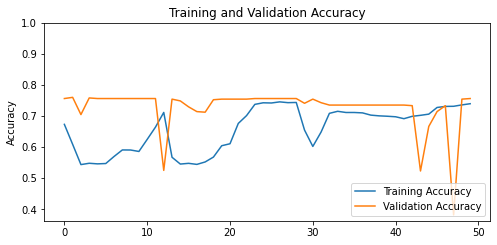

In [ ]:
# Try Simple CNN model as baseline
inputs = tf.keras.Input(shape=(img_height, img_width,3)) 
x = data_augmentation(inputs)
x = normalization_layer(x)

x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu' )(x)
x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu' )(x)
                           # ,kernel_regularizer=tf.keras.regularizers.L2(0.00001))(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu' )(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu' )(x)
                           # ,kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.models.Model(inputs, outputs)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['binary_accuracy'])
early=tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50, verbose=1, baseline=0.50)
history = model.fit(train_ds, batch_size = 256, epochs= 80, verbose=1, callbacks=[early], 
            validation_data = val_ds)
	
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


In [ ]:
# Evalation

print('CNN MODEL')
predictions = model.predict_on_batch(test_image).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1).numpy()

acc = (predictions ==  test_labels )
print('Accuracy :' ,sum(acc)/len(acc))

confusionMatrix = tf.math.confusion_matrix(
     test_labels , predictions, num_classes=2
).numpy()

# False Negatives = ppl who has pneunomia are predicted as pneunomia free
precision = confusionMatrix[0][0]/(confusionMatrix[0][0]+confusionMatrix[0][1]) #tp/tp+fp
recall = confusionMatrix[0][0]/(confusionMatrix[0][0] + confusionMatrix[1][0]) # tp/tp+fn

print('Precision : ', precision)
print(f'When the model predicts that a person has pnuemonia, {precision}% of time it is correct')
print('Recall : ', recall )
print(f'{recall}% of pnuemonia detected')

CNN MODEL
Accuracy : 0.59375
Precision :  0.0
When the model predicts that a person has pnuemonia, 0.0% of time it is correct
Recall :  nan
nan% of pnuemonia detected


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in int_scalars


## Transfer Learning ##

In [ ]:
# Preprocessing for pretrained model
preprocess_input = tf.keras.applications.resnet.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
IMG_SHAPE = (224, 224) + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

94773248/94765736 [==============================] - 2s 0us/step


In [ ]:
# Transfer Learning Model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x =  tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Dense(1)(x)
x = tf.keras.layers.BatchNormalization()(x)
transfer_model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Pre trained model without fine tuning
loss0, accuracy0 = model.evaluate(val_ds)

5/5 [==============================] - 1s 148ms/step - loss: 3.7033 - binary_accuracy: 0.7572


In [ ]:
# Fine Tuning
initial_epochs = 20
history = transfer_model.fit(train_ds, batch_size=256,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/20
37/37 [==============================] - 47s 1s/step - loss: 0.4558 - accuracy: 0.7123 - val_loss: 0.8933 - val_accuracy: 0.2524
Epoch 2/20
37/37 [==============================] - 35s 943ms/step - loss: 0.2677 - accuracy: 0.8713 - val_loss: 0.5800 - val_accuracy: 0.5545
Epoch 3/20
37/37 [==============================] - 35s 942ms/step - loss: 0.2140 - accuracy: 0.9216 - val_loss: 0.4471 - val_accuracy: 0.7476
Epoch 4/20
37/37 [==============================] - 35s 942ms/step - loss: 0.1773 - accuracy: 0.9393 - val_loss: 0.3278 - val_accuracy: 0.8413
Epoch 5/20
37/37 [==============================] - 35s 941ms/step - loss: 0.1491 - accuracy: 0.9520 - val_loss: 0.2108 - val_accuracy: 0.9159
Epoch 6/20
37/37 [==============================] - 35s 939ms/step - loss: 0.1302 - accuracy: 0.9584 - val_loss: 0.1789 - val_accuracy: 0.9446
Epoch 7/20
37/37 [==============================] - 35s 941ms/step - loss: 0.1226 - accuracy: 0.9647 - val_loss: 0.1601 - val_accuracy: 0.9484
Ep

Text(0.5, 1.0, 'Training and Validation Accuracy')

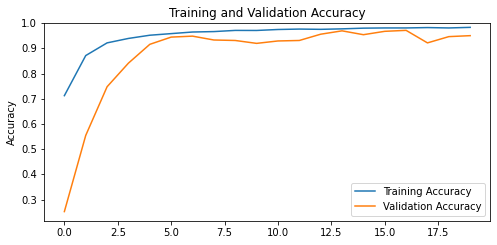

In [ ]:
# Training Statistics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


In [ ]:
# Evalation

predictions = transfer_model.predict_on_batch(test_image).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1).numpy()

acc = (predictions ==  test_labels )
print('Accuracy :' ,sum(acc)/len(acc))

confusionMatrix = tf.math.confusion_matrix(
     test_labels , predictions, num_classes=2
).numpy()
print(confusionMatrix)
# False Negatives = ppl who has pneunomia are predicted as pneunomia free
precision = confusionMatrix[0][0]/(confusionMatrix[0][0]+confusionMatrix[0][1]) #tp/tp+fp
recall = confusionMatrix[0][0]/(confusionMatrix[0][0] + confusionMatrix[1][0]) # tp/tp+fn

print('Precision : ', precision)
print(f'When the model predicts that a person has pnuemonia, {precision}% of time it is correct')
print('Recall : ', recall )
print(f'{recall}% of pnuemonia detected')

Accuracy : 0.8828125
[[40 12]
 [ 3 73]]
Precision :  0.7692307692307693
When the model predicts that a person has pnuemonia, 0.7692307692307693% of time it is correct
Recall :  0.9302325581395349
0.9302325581395349% of pnuemonia detected


In [ ]:
transfer_model.save('resnet50_xray.h5')
transfer_model.save_weights('resnet50_xray_test88%')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
